In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import emoji
import string
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer



In [2]:
# enter here
sms = pd.read_csv("sms_spam.csv", encoding="ISO-8859-1")
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# enter here
sms = sms[['v1', 'v2']]
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# enter here
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# enter here
# sms['label'] = sms['label'].map({"ham":0, "spam":1})
sms['label'] = sms['label'].apply(lambda x: 1 if x == "spam" else 0)
sms.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# enter here
# stro = ['er hello thing didnû÷t quit plan ûò limp slowli home follow exhaust hang','hope wasnû÷t piss rememb gone sister someth','basdsad']
# accented_string = u'Málaga'
import unidecode

sms['message'] = sms['message'].str.strip()

sms['message'] = sms['message'].str.lower()

sms['message'] = sms['message'].apply(lambda x: x.encode('ascii','ignore'))
sms['message'] = sms['message'].apply(lambda x: x.decode('utf-8'))

sms['length'] = sms['message'].apply(lambda x: len(x))

sms.head()


,label,message,length
0,0,"go until jurong point, crazy.. available only ...",111
1,0,ok lar... joking wif u oni...,29
2,1,free entry in 2 a wkly comp to win fa cup fina...,155
3,0,u dun say so early hor... u c already then say...,49
4,0,"nah i don't think he goes to usf, he lives aro...",61


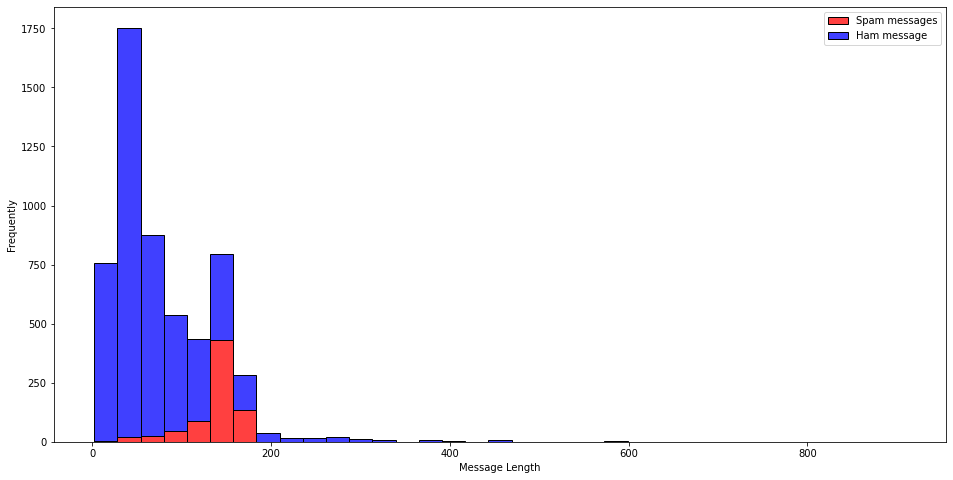

In [7]:
# sms
def histplot(data, x, hue, bins):
    ax = plt.figure(figsize = (16, 8))
    ax = sns.histplot(data = data, x  = x, hue= hue, palette = ['blue','red'],
                  bins =35, multiple="stack")
    plt.legend(labels=['Spam messages', 'Ham message'])
    ax.set(xlabel='Message Length', ylabel='Frequently')
histplot(sms, "length", "label", 35)


In [8]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_urls(self, text):
        return re.sub(r'http.://[^\s]+[\s]?', '', text)
    def emoji_oneword(self, text):
        return text.replace('_','')
    def remove_punctuation(self, text):
        punct = string.punctuation
        
        trantab = str.maketrans(punct, len(punct)*' ')
        
        return text.translate(trantab)
    def remove_digits(self, text):
        return re.sub('\d+', '', text)
    def to_lower(self, text):
        return text.lower()
    def remove_stopwords(self, text):
        stopwords_list = stopwords.words('english')
        whitelist = ["n't", "not", "no", 'u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
        words = text.split()
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word.strip()) > 2] 
        return " ".join(clean_words) 
    def stemming(self, text):
        porter = PorterStemmer()
        words = text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    def fit(self, x, y = None, **fit_params):
        return self
    def transform(self, x, **transform_params):
        clean_x = x.apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_x
    

In [9]:
cleaning_data = CleanText()
cleaned_data = cleaning_data.transform(sms["message"])
for i in range(len(cleaned_data)):
    sms["message"].iloc[i] = cleaned_data[i]
    sms["length"].iloc[i] = sms["message"].apply(lambda x:len(x)).iloc[i]


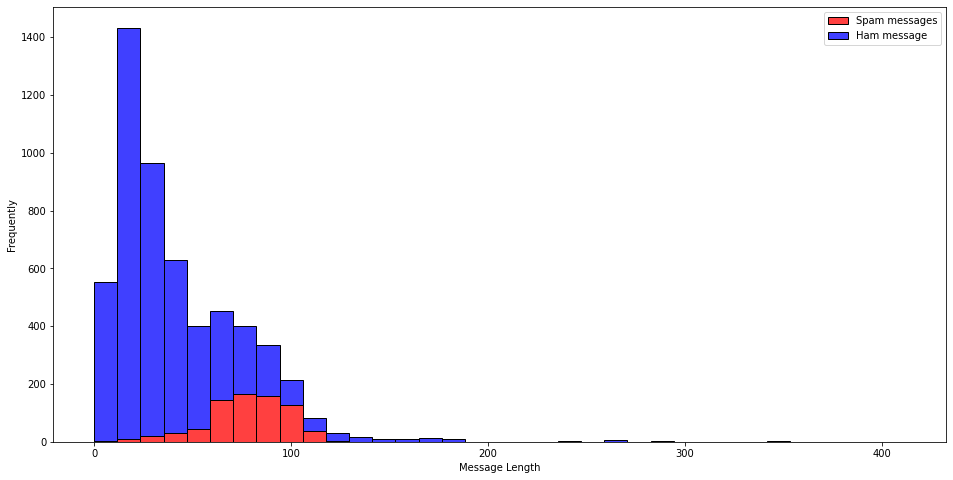

In [10]:
histplot(sms, "length", "label", 35)


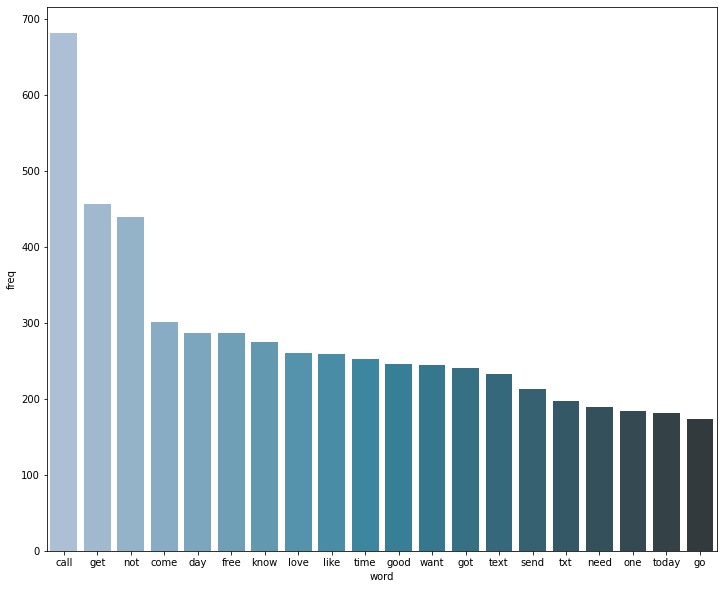

In [11]:
import collections
cv = CountVectorizer()
bow = cv.fit_transform(cleaned_data)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();



In [12]:
# sms['label'] = sms['label'].apply(lambda x: 1 if x == "spam" else 0)
# spam == 1 and ham == 0
ham = sms[sms['label'] == 0]
spam = sms[sms['label'] == 1]
ham_mess = ham.message.str.cat(sep=' ')
spam_mess = spam.message.str.cat(sep=' ')
wordcloud_ham = WordCloud(background_color='white').generate(ham_mess)
wordcloud_spam = WordCloud(background_color='white').generate(spam_mess)


Text(0.5, 1.0, 'Message with ham')

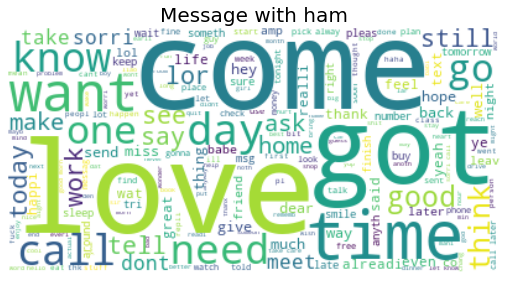

In [13]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_ham,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Message with ham',fontsize=20)

Text(0.5, 1.0, 'Message with spam')

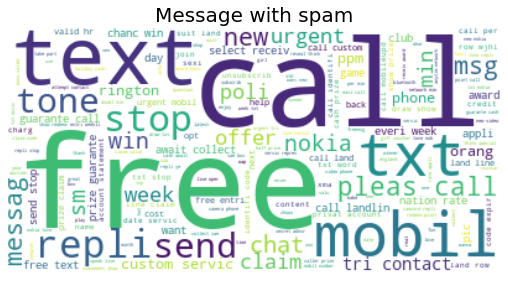

In [14]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_spam,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Message with spam',fontsize=20)

In [15]:
# enter here
import random
# x_train, x_test, y_train, y_test = train_test_split(sms['message'], sms['label'])
random.seed(42)
def Extract_Feature(extract_feature_model, features):
    if extract_feature_model == 'tfidf_vect':
        print("Tfidf Vectorizer")
        tfidf_vect = TfidfVectorizer(analyzer='word', max_features=3000)
        tfidf_vect.fit(features)
        vectors =  tfidf_vect.transform(features)
        return vectors
    elif extract_feature_model == 'count_vect' :
        print('Count Vectorizer')
        count_vect = CountVectorizer()
        count_vect.fit(features)
        vectors = count_vect.transform(features)
        return vectors
    else:
        print("Hashing Vectorizer")
        hashing = HashingVectorizer()
        vectors = hashing.fit_transform(features)
        return vectors
tfidf_vect_features = Extract_Feature('tfidf_vect', sms['message'])        
count_vect_features = Extract_Feature('count_vect',sms['message'])
hasing_vect_features = Extract_Feature('hasing_vect',sms['message'])

Tfidf Vectorizer
Count Vectorizer
Hashing Vectorizer


In [16]:
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
import random 
import time
np.random.seed(42)
def Machine_Learning_Model(name_model_extract_feature,features, outcome,k_fold,data_sms):
    x = features
    y = data_sms[outcome]
    kf = KFold(n_splits=k_fold)
    accuracy = []
    count = 1
    for train_index, test_index in kf.split(features):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = tree.DecisionTreeClassifier()
        model.fit(X_train,y_train)
        y_pred= model.predict(X_test)
        accuracy_entropy = accuracy_score(y_pred, y_test)
        
        accuracy.append(accuracy_entropy)
        count += 1
    return accuracy

In [17]:
tfidf_acc = Machine_Learning_Model("TF-IDF Vectorizer",tfidf_vect_features,"label",5,sms)
dataFrame_tfidf_acc = pd.DataFrame([tfidf_acc,['TF-IDF Vectorizer' for i in range(5)],['k_folds'+str(i) for i in range(1,6)]]).T
dataFrame_tfidf_acc.columns = ['accuracy', 'model_extraction','k_folds']
print(dataFrame_tfidf_acc['accuracy'].mean())
dataFrame_tfidf_acc
# TF-IDF Vectorizer,
# Hashing Vectorizer
# Count Vectorizer

0.9603362021077038


,accuracy,model_extraction,k_folds
0,0.959641,TF-IDF Vectorizer,k_folds1
1,0.967713,TF-IDF Vectorizer,k_folds2
2,0.965889,TF-IDF Vectorizer,k_folds3
3,0.950628,TF-IDF Vectorizer,k_folds4
4,0.957810,TF-IDF Vectorizer,k_folds5


In [18]:
count_acc = Machine_Learning_Model("Count Vectorizer",count_vect_features,"label",5,sms)

dataFrame_count_acc = pd.DataFrame([count_acc,['Count Vectorizer' for i in range(5)],['k_folds'+str(i) for i in range(1,6)]]).T
dataFrame_count_acc.columns = ['accuracy', 'model_extraction','k_folds']
print(dataFrame_count_acc['accuracy'].mean())
dataFrame_count_acc

0.9689517031502847


,accuracy,model_extraction,k_folds
0,0.968610,Count Vectorizer,k_folds1
1,0.970404,Count Vectorizer,k_folds2
2,0.969479,Count Vectorizer,k_folds3
3,0.965889,Count Vectorizer,k_folds4
4,0.970377,Count Vectorizer,k_folds5


In [19]:
hasing_acc = Machine_Learning_Model("Hashing Vectorizer",hasing_vect_features,"label",5,sms)
dataFrame_hasing_acc = pd.DataFrame([hasing_acc,['Hashing Vectorizer' for i in range(5)],['k_folds'+str(i) for i in range(1,6)]]).T
dataFrame_hasing_acc.columns = ['accuracy', 'model_extraction','k_folds']
print(dataFrame_hasing_acc['accuracy'].mean())
dataFrame_hasing_acc

0.9655407331073738


,accuracy,model_extraction,k_folds
0,0.970404,Hashing Vectorizer,k_folds1
1,0.967713,Hashing Vectorizer,k_folds2
2,0.971275,Hashing Vectorizer,k_folds3
3,0.957810,Hashing Vectorizer,k_folds4
4,0.960503,Hashing Vectorizer,k_folds5


In [20]:
acc_table = dataFrame_tfidf_acc.append(dataFrame_count_acc)
acc_table = acc_table.append(dataFrame_hasing_acc)

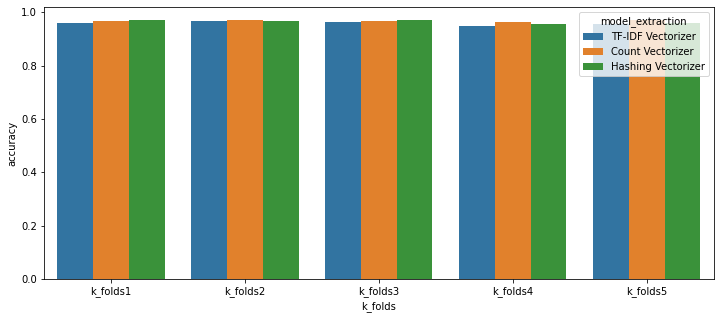

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = sns.barplot(x="k_folds", y="accuracy", hue="model_extraction", data=acc_table)